AIM: In this notebook, we will run through the deduplication algorithm in steps and see what outputs are generated after each step. Finally, we will run the algorithm on simulated data to visualize the clusters formed of similar documents using our algorithm.

In [ ]:
!pip install datasets

In [3]:
from datasets import load_dataset
import random
import random
import hashlib
from collections import defaultdict
from collections import deque
import numpy as np
from visualize import visualize_clusters

In [4]:
def get_ngrams(text, n=5):
    tokens = text.split()
    return set(tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1))

def hash_fn(seed):
    def h(x):
        return int(hashlib.md5((str(seed) + str(x)).encode()).hexdigest(), 16)
    return h                                                                                                     

def generate_signature(ngrams, num_hashes=128):
    hash_functions = [hash_fn(i) for i in range(num_hashes)]
    return [min(h(gram) for gram in ngrams) for h in hash_functions]



def lsh(signature, num_bands=16, rows_per_band=8):
    assert len(signature) == num_bands * rows_per_band
    buckets = []
    for b in range(num_bands):
        band = tuple(signature[b * rows_per_band : (b + 1) * rows_per_band])
        buckets.append(hash(band))
    return buckets


In [5]:
def generate_test_documents(total_unique_documents=700, total_num_repeated_documents=300, seed=42):
    """
    Generates a synthetic test dataset from real documents with duplicates.

    Args:
        total_unique_documents (int): Number of unique source documents to include
        total_num_repeated_documents (int): Number of repeated documents to inject
        seed (int): Random seed for reproducibility

    Returns:
        List[str]: All documents (unique + duplicates), shuffled
    """
    random.seed(seed)
    
    # Step 1: Load AG News dataset
    dataset = load_dataset("ag_news", split="train")
    
    # Step 2: Select unique documents
    docs = [item['text'] for item in dataset.select(range(total_unique_documents))]

    # Step 3: Add randomly repeated documents
    duplicate_docs = random.choices(docs, k=total_num_repeated_documents)
    
    # Step 4: Combine and shuffle
    all_docs = docs + duplicate_docs
    random.shuffle(all_docs)
    
    return all_docs

In [6]:
docs = generate_test_documents()

README.md: 0.00B [00:00, ?B/s]

C:\Users\HarshNigam\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HarshNigam\.cache\huggingface\hub\datasets--ag_news. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [7]:
docs[0]

'Simultaneous Tropical Storms are Very Rare The prospect that a tropical storm and a hurricane - or possibly two hurricanes - could strike Florida on the same day is something meteorologists say they have never seen. "It\'s almost unheard of," state meteorologist Ben Nelson said.'

In [16]:
ngrams = get_ngrams(docs[0])
list(ngrams)[: 5]

[('Tropical', 'Storms', 'are', 'Very', 'Rare'),
 ('or', 'possibly', 'two', 'hurricanes', '-'),
 ('are', 'Very', 'Rare', 'The', 'prospect'),
 ('Very', 'Rare', 'The', 'prospect', 'that'),
 ('meteorologists', 'say', 'they', 'have', 'never')]

In [19]:
signatures = generate_signature(ngrams)
print(type(signatures), len(signatues))

<class 'list'> 128


In [22]:
buckets = lsh(signatures)
print("No. of buckets per document", len(buckets))
print(buckets)

No. of buckets per document 16
[9009708901022217209, -2462410616927244506, 224011730179755554, 4517018914731504484, 5380297280357784743, -9106264452325014326, 5145948404533556118, -1706680932908675940, -4416441882850372748, -523414441339610661, -8908114041049226572, -2976921918314983931, -1716618446744502339, -6821250784520237401, 4706360782517847759, -8149282332941077097]


Now lets run the above algorithm for all the documents and build our clusters by comparing bucket hashes of documents and using BFS to connect similar documents

In [23]:
def lsh_cluster_documents(documents, num_hashes=112, num_bands=14, ngram_n=5):
    """
    Applies MinHash + LSH to cluster near-duplicate documents.

    Args:
        documents (List[str]): List of document strings
        num_hashes (int): Length of MinHash signature
        num_bands (int): Number of bands to split signature into
        ngram_n (int): Size of n-grams to use for shingling

    Returns:
        clusters (List[Set[int]]): List of sets of doc IDs (clusters)
        doc_signatures (List[List[int]]): MinHash signatures for each doc
    """
    rows_per_band = num_hashes // num_bands

    buckets = defaultdict(set)  # (band_idx, hash) → doc_ids
    doc_signatures = []

    for doc_id, doc in enumerate(documents):
        n_grams = get_ngrams(doc, n=ngram_n)
        signature = generate_signature(n_grams, num_hashes)
        doc_signatures.append(signature)

        band_hashes = lsh(signature, num_bands, rows_per_band)
        for band_idx, band_hash in enumerate(band_hashes):
            bucket_key = (band_idx, band_hash)
            buckets[bucket_key].add(doc_id)

    # Invert: doc_id → list of buckets
    doc_to_clusters = defaultdict(set)
    for (band_idx, band_hash), doc_ids in buckets.items():
        if len(doc_ids) > 1:
            for doc_id in doc_ids:
                doc_to_clusters[doc_id].add((band_idx, band_hash))

    # Build connected components (clusters)
    visited = set()
    clusters = []

    for doc_id in range(len(documents)):
        if doc_id in visited:
            continue
        cluster = set()
        queue = deque([doc_id])
        while queue:
            current = queue.popleft()
            if current in visited:
                continue
            visited.add(current)
            cluster.add(current)
            for band_pair in doc_to_clusters[current]:
                queue.extend(buckets[band_pair] - visited)
        if len(cluster) > 1:
            clusters.append(cluster)

    return clusters, doc_signatures

In [24]:
clusters, doc_signatures = lsh_cluster_documents(docs)

In [ ]:
Upon building clusters, 

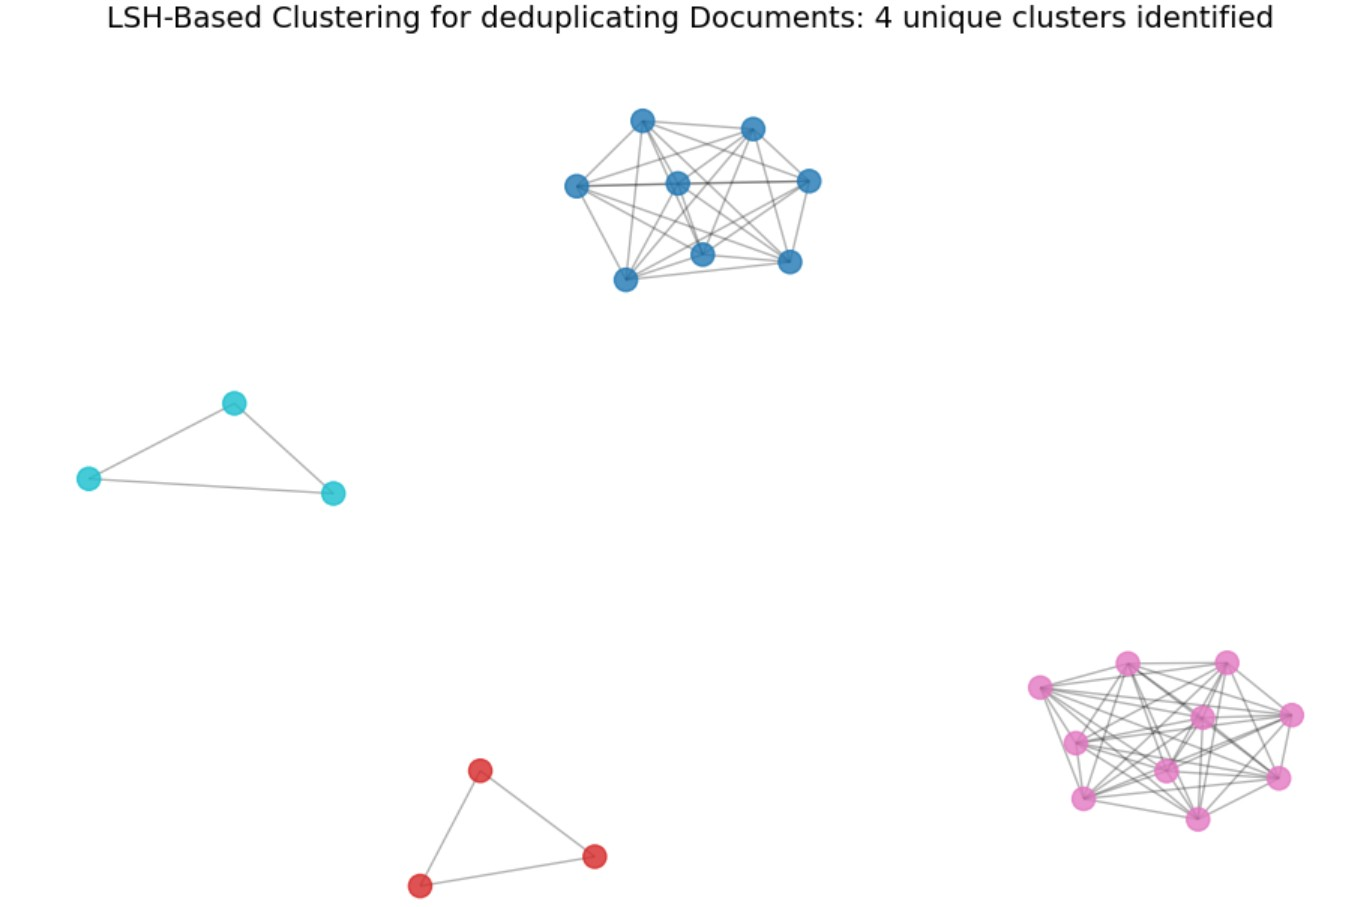